# Определение возраста покупателей

**Источник данных:** данные с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

**Характер данных:** набор фотографий людей с указанием возраста.

**Цель заказчика:** внедрение системы компьютерного зрения для обработки фотографий покупателей (фотофиксация в прикассовой зоне с целью определять возраст клиентов), чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
* Контролировать добросовестность кассиров при продаже алкоголя.

**Задача исследования:** построить модель, которая по фотографии определит приблизительный возраст человека.

**Условия обучения модели:** метрика MAE < 8.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import pathlib
import random

from tensorflow import keras
from keras import models, optimizers, utils
from keras.preprocessing import image

import keras.layers as l

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка данных

Задание функции, выводящей произвольное изображение из набора данных:

In [2]:
def plot_random_image(target_dir: str, data_df: pd.DataFrame, depth: str = '*') -> None:
    image_paths = list(pathlib.Path(target_dir).glob(f'{depth}.jpg'))
    image_random = random.choice(image_paths)
    image_name = image_random.name
    
    img = Image.open(image_random)
    
    print('Путь к изображению:', image_random)
    print(f'Высота: {img.height} | Ширина: {img.width}')
    
    img = np.array(img)
    plt.imshow(img)
    
    print(f'Размерность изображения {img.shape} -> [height, width, color_channels]')    
    print(f'\nВозраст:', data_df.query('file_name == @image_name')['real_age'].item())

---

Задание путей до файлов:

In [3]:
path_data = '/datasets/faces'
path_images = f'{path_data}/final_files'
path_labels = f'{path_data}/labels.csv'

Загрузка набора данных:

In [4]:
data = pd.read_csv(path_labels)

Выведение на экран первых пяти строк набора данных:

In [5]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выведение на экран размерности данных:

In [6]:
print('Размерность данных:', data.shape)

Размерность данных: (7591, 2)


Выведение на экран общего числа уникальных классов:

In [7]:
print('Всего классов:', data['real_age'].nunique())

Всего классов: 97


Выведение на экран уникальных значений столбца с целевым признаком:

In [8]:
data['real_age'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

Выведение на экран произвольного изображения из набора данных:

Путь к изображению: /datasets/faces/final_files/004145.jpg
Высота: 375 | Ширина: 375
Размерность изображения (375, 375, 3) -> [height, width, color_channels]

Возраст: 2


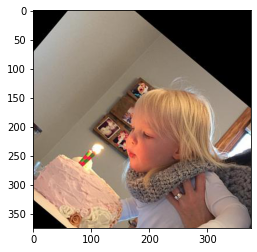

In [9]:
plot_random_image(path_images, data)

Задание параметров загрузчика данных:

In [10]:
image_params = {
    'validation_split': 0.25,
    'rescale': 1./255
}

Задание загрузчиков данных:

In [11]:
train_datagen = image.ImageDataGenerator(**image_params)
valid_datagen = image.ImageDataGenerator(**image_params)

Задание параметров для формирования датасетов:

In [12]:
flow_params = {
    'dataframe': data,
    'directory': path_images,
    'x_col': 'file_name',
    'y_col': 'real_age',
    'target_size': (150, 150),
    'batch_size': 16,
    'class_mode': 'raw',
    'seed': 12345
}

Извлечение данных из папок с формированием пар изображений с метками классов и разделением на тренировочную и валидационную выборки:

In [13]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    **flow_params, subset='training'
)

valid_datagen_flow = valid_datagen.flow_from_dataframe(
    **flow_params, subset='validation'
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Исследовательский анализ данных

Задание функции, выводящей размерности экземпляров датасета:

In [14]:
def print_data_info(data_flow: image.DataFrameIterator) -> None:
    features, target = next(data_flow)
    
    print(f'Размерность экземпляра признаков: {features.shape} -> [batch_size, height, width, color_channels]')
    print(f'Размерность элемента экземпляра признаков: {features[0].shape} -> [height, width, color_channels]')
    
    print(f'\nРазмерность экземпляра целевых признаков: {target.shape}')

Задание функции, выводящей изображения из сформированного датасета:

In [15]:
def plot_images(data_flow: image.DataFrameIterator, n_images: int) -> None:
    features, target = next(data_flow)
    max_images = features.shape[0]
    
    n_cols = 5
    
    if n_images > max_images:
        n_images = max_images
        print(f'Для корректной взуализации значение n_images было ограничено размером батча до {max_images}')
    
    if n_images % n_cols != 0:
        if n_images < n_cols:
            n_images = n_cols
        else:
            n_images = (n_images // n_cols) * n_cols 
            
        print(f'Для корректной взуализации значение n_images было установлено как кратное {n_cols}')
    
    n_rows = n_images // n_cols + int((n_images % n_cols) / 10)
    n_rows = n_rows if n_rows != 0 else 1
        
    fig = plt.figure(figsize=(16, n_images / 2))
    
    for i in range(n_images):
        fig.add_subplot(n_rows, n_cols, i+1)
        plt.title(f'Возраст: {target[i]}')
        plt.imshow(features[i])
        
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()

Задание функции построения графика распределния значений в столбце набора данных:

In [16]:
def plot_value_distribution(data_df: pd.Series, n_bins: int = 100, xsticks_step: int = 1) -> None:
    font_s = 12
    
    data_df.plot.hist(bins=n_bins, figsize=(16, 6))
    
    plt.title('Распределение возраста\n', fontsize=font_s+4)
    
    if xsticks_step is not None:
        plt.xticks(range(0, max(data_df), xsticks_step), rotation=0)    

    plt.xlabel('age', fontsize=font_s)
    plt.ylabel('frequency', fontsize=font_s)

    plt.grid()
    plt.show()

---

### Анализ

Выведение на экран распределения значений целевого признака:

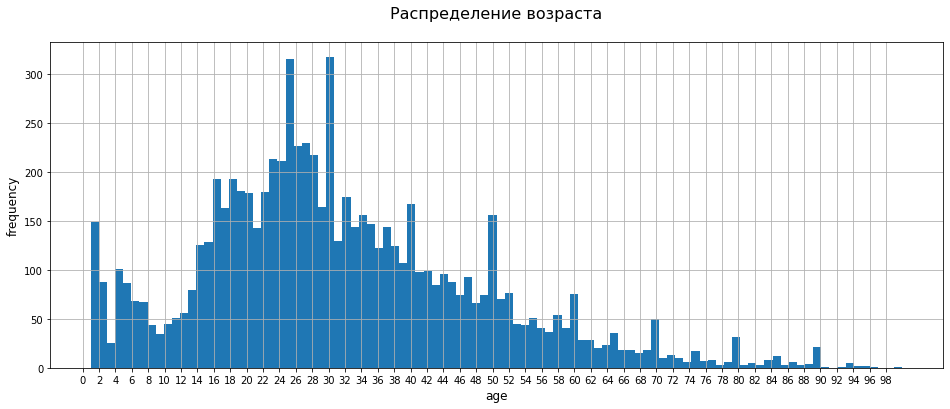

In [17]:
plot_value_distribution(data['real_age'], xsticks_step=2)

Выведение на экран 

In [18]:
pd.DataFrame(data['real_age'].describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


>Превалирующее большинство фотографий размечены возрастом от 13 до 52 лет и от 1 года до 5 лет.

Выведение на экран размерностей экземпляров датасета:

In [19]:
print_data_info(train_datagen_flow)

Размерность экземпляра признаков: (16, 150, 150, 3) -> [batch_size, height, width, color_channels]
Размерность элемента экземпляра признаков: (150, 150, 3) -> [height, width, color_channels]

Размерность экземпляра целевых признаков: (16,)


Выведение на экран изображений из датасета:

Для корректной взуализации значение n_images было ограничено размером батча до 16
Для корректной взуализации значение n_images было установлено как кратное 5


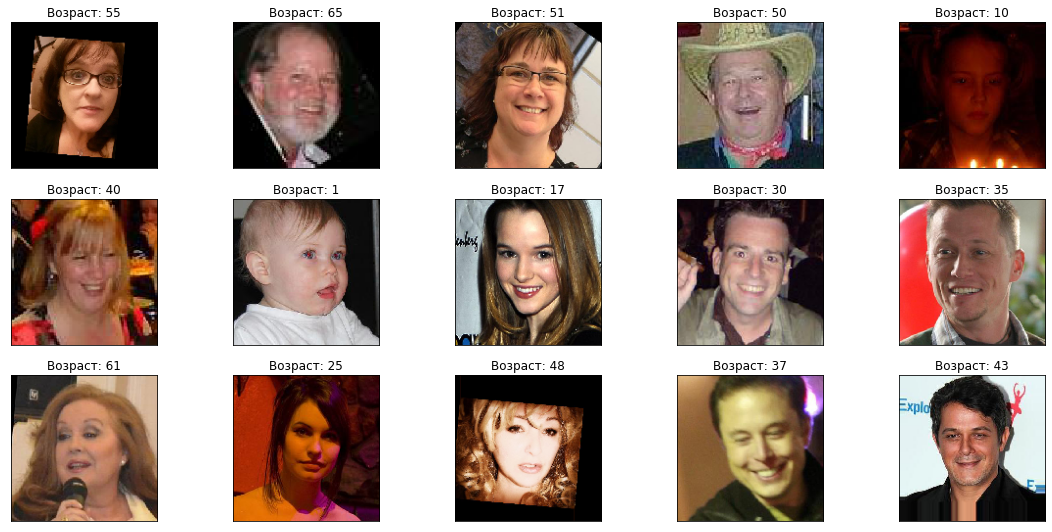

In [20]:
plot_images(train_datagen_flow, 25)

>Данные представлены в разном размере, поскольку часть из них несколько потеряла в качестве после приведения изображений к единому размеру.

---

### Вывод

Исходя из проведённого анализа предоставленных данных, а также таблицы с их разметкой, можно заключить, что построение заданной модели по определению возраста на основании фотографии возможно.

Поскольку общего числа изображений в тренировочной выборке достаточно, можно произвести аугментацию данных, чтобы дать модели больше вариаций изображений, но в целом в этом нет необходимости - в данных уже присутствуют повёрнутые и искривлённые изображения. Далее нужно обучить модель и проанализировать результат. 

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Обучение модели

Разбор поставленной перед исследованием задачи:

Вопрос | Ответ
--- | --- |
Тип решаемой задачи | Задача регрессии
Количество выходных нейронов | 1
Функция активации для нейрона | ReLU
Функция потерь | MSE
Метрики | MAE
Порог для функции потерь | $ < 8 $
Подход к решению задачи | Нейронные сети
Нейронная сеть | ResNet50
Предобученная | Да
Веса нейронной сети | `weights='imagenet'`
Заморозка сети | Не требуется
Ограничение по времени работы | $ < 30 $ минут
Произведение вычислений | GPU Yandex Compute Cloud
Аугментации данных | `horizontal_flip`

---

### Обучение

Импорт библиотек:

In [ ]:
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense

Задание констант:

In [ ]:
VALIDATION_SPLIT = .25
RESCALE = 1./255
DATAFRAME_PATH = lambda path: pd.read_csv(f'{path}/labels.csv')
DIRECTORY_PATH = lambda path: f'{path}/final_files'
X_COL = 'file_name'
Y_COL = 'real_age'
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
CLASS_MODE = 'raw'
SEED = 12345

Задание функции загрузки тренировочной выборки:

In [ ]:
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=VALIDATION_SPLIT,
        rescale=RESCALE,
        horizontal_flip=True
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=DATAFRAME_PATH(path),
        directory=DIRECTORY_PATH(path),
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        seed=SEED, 
        subset='training'
    )
    
    return train_datagen_flow

Задание функции загрузки валидационной выборки:

In [ ]:
def load_test(path):
    valid_datagen = ImageDataGenerator(
        validation_split=VALIDATION_SPLIT,
        rescale=RESCALE,
    )

    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=DATAFRAME_PATH(path),
        directory=DIRECTORY_PATH(path),
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        seed=SEED, 
        subset='validation'
    )
    
    return valid_datagen_flow

Задание функции формирования модели:

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='imagenet', 
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        optimizer=Adam(0.0001), 
        loss='mean_squared_error', 
        metrics=['mae']
    )
    return model

Задание функции обучения модели:

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

---

>Обучение было произведено на GPU Yandex Cloud.

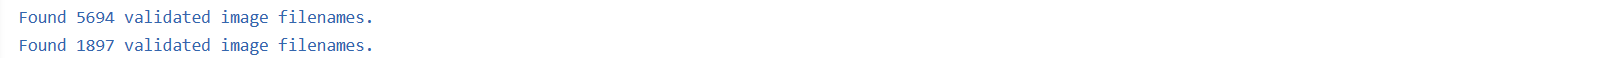

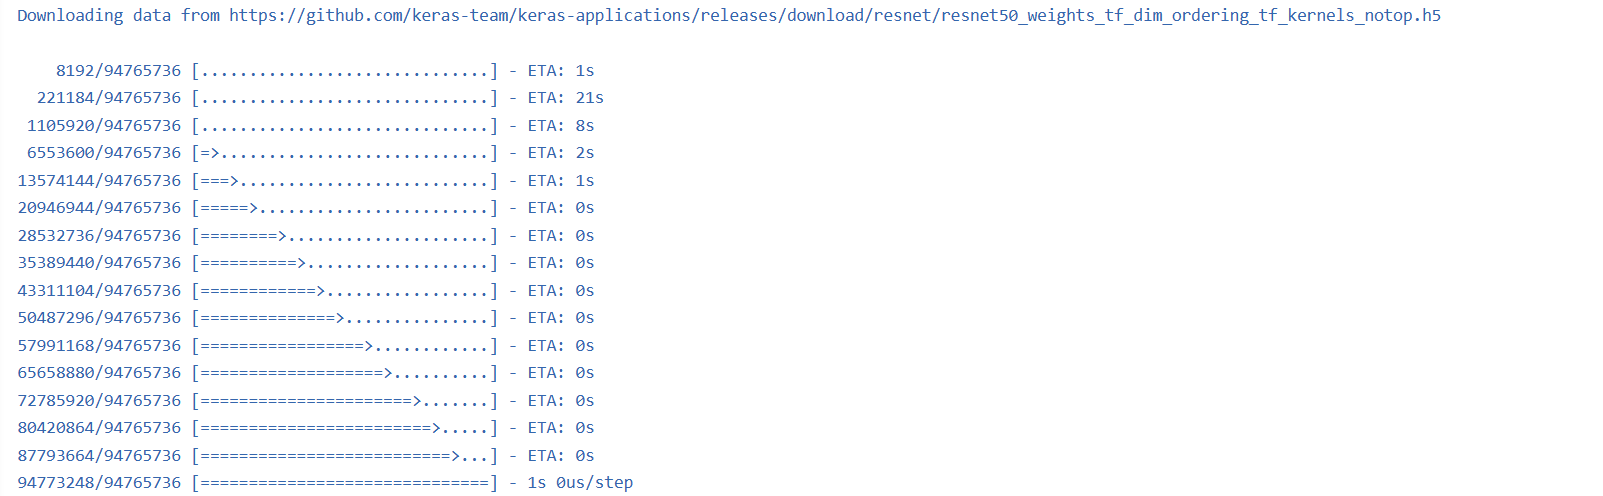

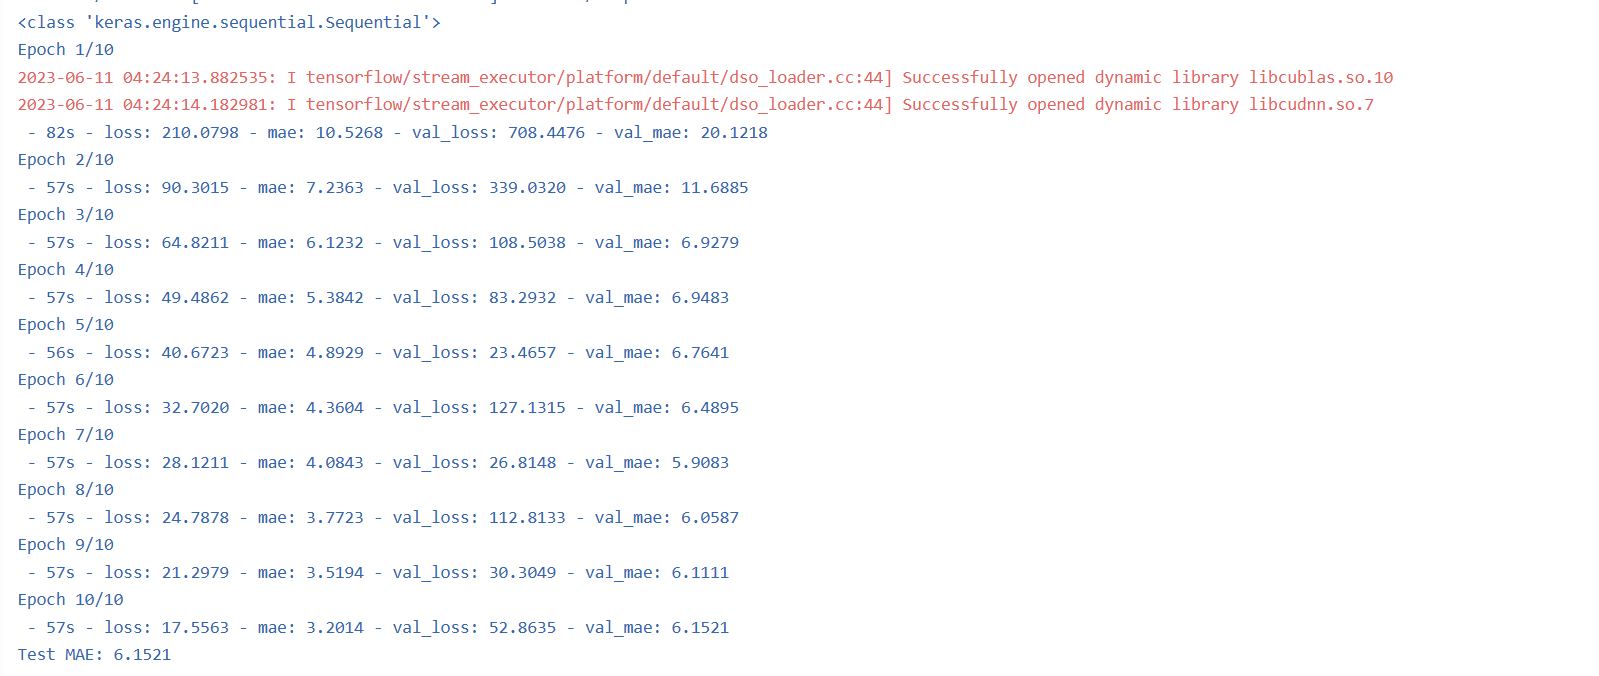

---

### Вывод

За 10 эпох удалось уменьшить значение функции потерь на валидационной выборке ниже заданного порога, что говорит о возможности дальнейшего его уменьшения при увеличении количества эпох. 

При этом не были применены никакие дополнительные аугментации при обработке изображений.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Анализ обученной модели

Поставленная задача по построению модели, способной по фотографии определить приблизительный возраст человека, была выполнена в два этапа: 1) предварительный анализ данных и 2) обучение модели. 

Обучение модели было проведено:

* Посредством предобученной нейронной сети ResNet50 (базовая модель + голова) с применением весов `imagenet` без заморозки сети. 
* С оптимальным размером батча 16. 
* В качестве оптимизатора был взят алгоритм Adam.
* Функцией потерь выступила MSE.
* Для отслеживания прогресса модели была взята метрика MAE.
* Модель продемонстрировала удовлетворяющий заданный порог метрики MAE за 10 эпох.

Результат обучения показал:

* Общее время обучения модели составило около 15 минут.

* По истечении 10 эпох метрика MAE опустилась на тренировоном наборе данных с ~11 до 3, а на валидационном - c 20 до 6.

* Начиная с 6-й эпохи функция потерь продемонстрировала переобучение на валидационной выборке.

Таким образом, модель справилась с поставленной задачей, подтвердив возможность её реализации.

---

Кроме того, по завершении проведённого исследования можно сделать следующие выводы:

* При произведении вычислений на сервере с GPU обучение нейронных сетей происходит в разы быстрее, чем на персональном компьютере с вычислениями на встроенной видеокарте.

* Нейросеть справилась с поставленной задачей даже без предобработки данных, а именно удалении записей с редко встречающимися целевыми признаками, когда в классическом машинном обучении для достижения необходимого порога было бы необходимо произвести качественную предобработку данных.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Определение-возраста-покупателей" data-toc-modified-id="Определение-возраста-покупателей" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>